#### Import the libraries

In [1]:
import numpy as np
# from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from shapely.geometry import Polygon

from parflow.tools.io import read_pfb
from parflow import Run
from parflow.tools.hydrology import calculate_surface_storage, calculate_subsurface_storage, \
    calculate_water_table_depth, calculate_evapotranspiration, calculate_overland_flow_grid, calculate_overland_fluxes
from matplotlib.colors import LogNorm

#### Load the data

In [2]:
folder = '/home/dica/huiminw/Work/Codes/Py/lombardy/0_clm_2023/'
runname = 'Calibration'

mask_watershed = np.loadtxt('/home/dica/huiminw/Work/Data/TXT/Mask.txt')
mask_watershed[mask_watershed == 0] = np.nan
watershed = mask_watershed

In [3]:
run = Run.from_definition(folder+runname+'.pfidb')
data = run.data_accessor

dx = data.dx
dy = data.dy
dz = data.dz
# dz = np.array([170, 40, 13, 1.4, 0.45, 0.15])
nx = data.shape[2]
ny = data.shape[1]
nz = data.shape[0]

porosity = data.computed_porosity
specific_storage = data.specific_storage
mask = data.mask
slopex = data.slope_x
slopey = data.slope_y
mannings = data.mannings
# et = data.et                        # shape (nz, ny, nx) - units 1/T.

  - nt
  - sw_ini
  - qflx_tran_vegm
  - hkdepth
  - wtfact
  - trsmx0
  - smpmax
  - pondmx


#### Overland Flow/ Stream Flow, Surface Storage, Subsurface Storage, WTD
For Parking Lot Test, it's not necessary to check the WTD, since the surface is almost impermeable.

In [4]:
# nt = 11 # nt = len(data.times), number of time steps
nt = [0, 12, 24, 36, 48, 60, 72, 84, 96, 108, 120]

Ssub_box3d, Ssur_box3d = np.zeros((len(nt), nz, ny, nx)), np.zeros((len(nt), nz, ny, nx))
Ssub_adda3d, Ssur_adda3d = np.zeros((len(nt), nz, ny, nx)), np.zeros((len(nt), nz, ny, nx))
et_box3d, et_adda3d = np.zeros((len(nt), nz, ny, nx)), np.zeros((len(nt), nz, ny, nx))
Ssub_boxtot, Ssur_boxtot = np.zeros(len(nt)), np.zeros(len(nt))
Ssub_addatot, Ssur_addatot = np.zeros(len(nt)), np.zeros(len(nt))
et_boxtot, et_addatot = np.zeros(len(nt)), np.zeros(len(nt))

wtd_box, wtd_adda = np.zeros((len(nt), ny, nx)), np.zeros((len(nt), ny, nx))
olflowgrid_box, olfowgrid_adda = np.zeros((len(nt), ny, nx)), np.zeros((len(nt), ny, nx))

for i in range(11):
    pressure = data.pressure
    saturation = data.saturation
    # et = data.et

    # Total subsurface storage for this time step is the summation of substorage surface across all x/y/z slices
    # Ssub_boxtot[i] = np.nansum(calculate_subsurface_storage(porosity, pressure, saturation, specific_storage, dx, dy, dz, mask=mask), axis=(0, 1, 2))
    Ssub_box3d[i, ...] = calculate_subsurface_storage(porosity, pressure, saturation, specific_storage, dx, dy, dz, mask=mask)
    Ssub_boxtot[i] = np.nansum(Ssub_box3d[i, ...], axis=(0, 1, 2))

    # Ssub_addatot[i] = np.nansum(calculate_subsurface_storage(porosity, pressure, saturation, specific_storage, dx, dy, dz, mask=mask), axis=(0, 1, 2))
    Ssub_adda3d[i, ...] = calculate_subsurface_storage(porosity, pressure, saturation, specific_storage, dx, dy, dz, mask=mask)*np.flip(watershed, axis=0)
    Ssub_addatot[i] = np.nansum(Ssub_adda3d[i, ...], axis=(0, 1, 2))

    # Total surface storage for this time step is the summation of substorage surface across all x/y slices
    Ssur_box3d[i, ...] = calculate_surface_storage(pressure, dx, dy, mask=mask)
    # Ssur_boxtot = np.nansum(Ssur_box3d, axis=(0, 1))
    Ssur_boxtot[i] = np.nansum(calculate_surface_storage(pressure, dx, dy, mask=mask), axis=(0, 1))

    Ssur_adda3d[i, ...] = calculate_surface_storage(pressure, dx, dy, mask=mask)*np.flip(watershed, axis=0)
    Ssur_addatot[i] = np.nansum(calculate_surface_storage(pressure, dx, dy, mask=mask)*np.flip(watershed, axis=0), axis=(0, 1))

    # et_box3d[i, ...] = calculate_evapotranspiration(et, dx, dy, dz, mask=mask)
    # et_boxtot[i] = np.nansum(et_box3d[i, ...],axis=(0, 1, 2))
    # et_adda3d[i, ...] = et_box3d[i, ...] * np.flip(watershed, axis=0)
    # et_addatot[i] = np.nansum(et_adda3d[i, ...],axis=(0, 1, 2))

    wtd_box[i, ...] = calculate_water_table_depth(pressure, saturation, dz)
    wtd_adda[i, ...] = wtd_box[i, ...]*np.flip(watershed, axis=0)

    olflowgrid_box[i, ...] = calculate_overland_flow_grid(pressure, slopex, slopey, mannings, dx, dy, flow_method='OverlandKinematic', epsilon=1e-5, mask=mask)
    olfowgrid_adda[i, ...] = olflowgrid_box[i, ...]*np.flip(watershed, axis=0)

    # data.time += 1

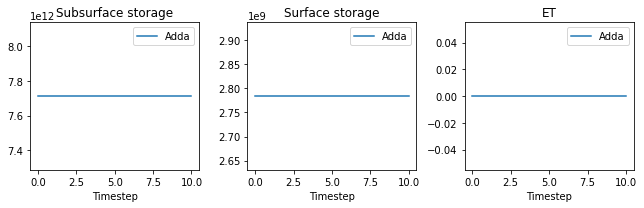

In [5]:
vars_box = [Ssub_boxtot, Ssur_boxtot, et_boxtot]
vars_adda = [Ssub_addatot, Ssur_addatot, et_addatot]
titles = ['Subsurface storage', 'Surface storage', 'ET']

plt.figure(figsize=(9, 3))
for ax, var_box, var_adda, title in zip([plt.subplot(131), plt.subplot(132), plt.subplot(133)], vars_box, vars_adda, titles):
    # ax.plot(var_box, label='Box')
    ax.plot(var_adda, label='Adda')
    ax.legend()
    ax.set_xlabel('Timestep')
    ax.set_title(f'{title}')
plt.tight_layout()

Text(0, 0.5, 'WTD (m)')

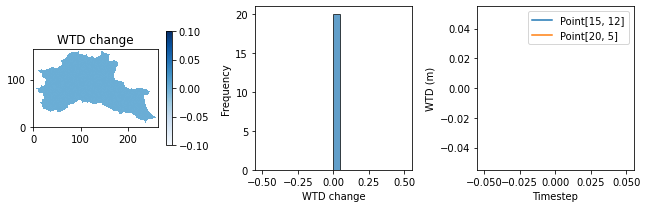

In [6]:
wtd_diff = (wtd_adda[-1, ...] - wtd_adda[-2, ...]) * np.flip(watershed, axis=0)

plt.figure(figsize=(9, 3))
plt.subplot(131)
plt.imshow(wtd_diff, cmap='Blues', origin='lower')
plt.colorbar(shrink=0.7)
plt.title('WTD change')

plt.subplot(132)
plt.hist(wtd_diff.flatten(), bins=20, density=True, edgecolor='black', alpha=0.7)
plt.xlabel('WTD change')
plt.ylabel('Frequency')
plt.tight_layout()

plt.subplot(133)
plt.plot(wtd_adda[:, 15,12], label='Point[15, 12]')
plt.plot(wtd_adda[:, 20,5], label='Point[20, 5]')
plt.legend()

# plt.semilogy()
plt.xlabel('Timestep')
plt.ylabel('WTD (m)')

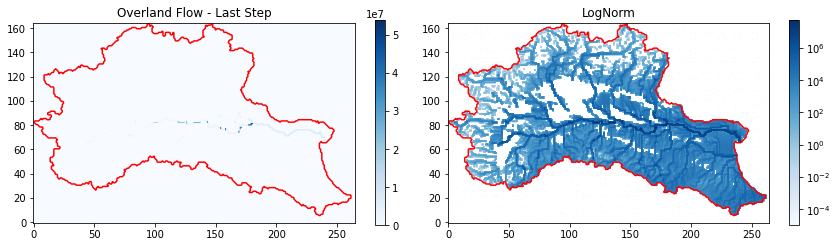

In [7]:
watershed[watershed != 1] = 0

# fig, axes = plt.subplots(2, 5, figsize=(20, 8))
# for i in range(nt):
#     ax = axes[i // 5, i % 5]
#     im = ax.imshow(olflow_grid_box[i, ...], cmap='Blues', origin='lower')
#     # if olflow_grid_box[i, ...].max() == 0:
#     #     im = ax.imshow(olflow_grid_box[i, ...], cmap='Blues', origin='lower')
#     # else:
#     #     im = ax.imshow(olflow_grid_box[i, ...], cmap='Blues', origin='lower', norm=LogNorm())
#     fig.colorbar(im, ax=ax, shrink=0.7)
#     ax.contour(np.flipud(watershed), levels=[0.5], colors='red', linewidths=1.5)
#     ax.set_title(f'Overland Flow - Step {i+1}')
# plt.tight_layout()

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
for ax, norm, title in zip(axes, [None, LogNorm()], ['Overland Flow - Last Step', 'LogNorm']):
    im = ax.imshow(olflowgrid_box[-1, ...], cmap='Blues', origin='lower', norm=norm)
    fig.colorbar(im, ax=ax, shrink=0.5)
    ax.contour(np.flipud(watershed), levels=[0.5], colors='red', linewidths=1.5)
    ax.set_title(title)
plt.tight_layout()


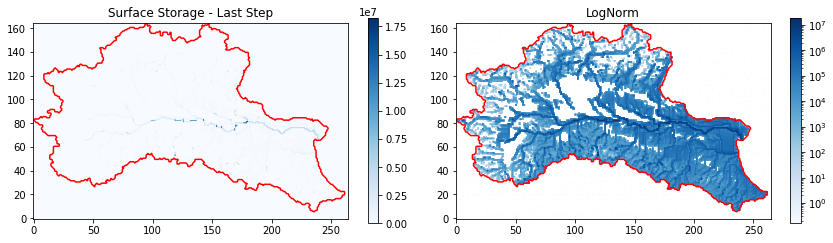

In [8]:
# fig, axes = plt.subplots(2, 5, figsize=(20, 8))
# for i in range(nt):
#     ax = axes[i // 5, i % 5]
#     # im = ax.imshow(Ssub_box3d[i, -1, :, :], cmap='Blues', origin='lower')
#     if Ssur_box3d[i, -1, :, :].max() == 0:
#         im = ax.imshow(Ssur_box3d[i, -1, :, :], cmap='Blues', origin='lower')
#     else:
#         im = ax.imshow(Ssur_box3d[i, -1, :, :], cmap='Blues', origin='lower', norm=LogNorm())
#     fig.colorbar(im, ax=ax, shrink=0.7)
#     ax.contour(np.flipud(watershed), levels=[0.5], colors='red', linewidths=1.5)
#     ax.set_title(f'Surface Storage - Step {i+1}')
# plt.tight_layout()

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
for ax, norm, title in zip(axes, [None, LogNorm()], ['Surface Storage - Last Step', 'LogNorm']):
    im = ax.imshow(Ssur_box3d[-1, -1, ...], cmap='Blues', origin='lower', norm=norm)
    fig.colorbar(im, ax=ax, shrink=0.5)
    ax.contour(np.flipud(watershed), levels=[0.5], colors='red', linewidths=1.5)
    ax.set_title(title)
plt.tight_layout()

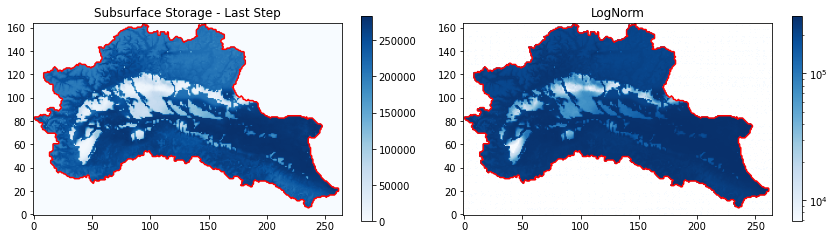

In [9]:
# fig, axes = plt.subplots(2, 5, figsize=(20, 8))
# for i in range(nt):
#     ax = axes[i // 5, i % 5]
#     # im= ax.imshow(Ssub_box3d[i, -1, :, :], cmap='Blues', origin='lower', vmin = 1.8e+4, vmax = 2.7e+4)
#     if Ssub_box3d[i, -1, :, :].max() == 0:
#         im = ax.imshow(Ssub_box3d[i, -1, :, :], cmap='Blues', origin='lower', vmin=1.5e+4, vmax=2.8e+4)
#     else:
#         im = ax.imshow(Ssub_box3d[i, -1, :, :], cmap='Blues', origin='lower', norm=LogNorm())
#     fig.colorbar(im, ax=ax, shrink=0.7)
#     ax.contour(np.flipud(watershed), levels=[0.5], colors='red', linewidths=1)
#     ax.set_title(f'Subsurface Storage - Step {i+1}')
# plt.tight_layout()

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
for ax, norm, title in zip(axes, [None, LogNorm()], ['Subsurface Storage - Last Step', 'LogNorm']):
    im = ax.imshow(Ssub_box3d[-1, -1, ...], cmap='Blues', origin='lower', norm=norm)
    fig.colorbar(im, ax=ax, shrink=0.5)
    ax.contour(np.flipud(watershed), levels=[0.5], colors='red', linewidths=1.5)
    ax.set_title(title)
plt.tight_layout()

Text(0, 0.5, 'Frequency')

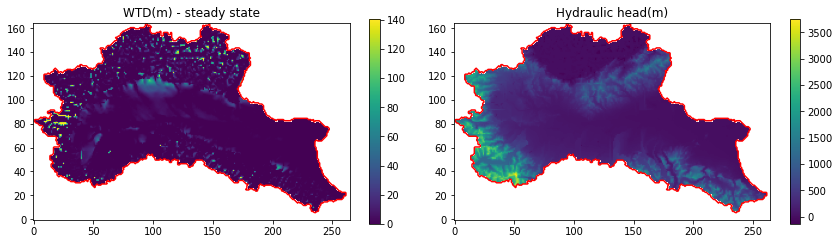

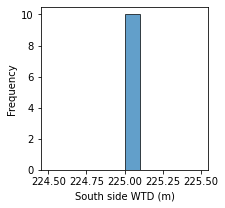

In [10]:
# fig, axes = plt.subplots(2, 5, figsize=(20, 8))
# for i in range(nt):
#     ax = axes[i // 5, i % 5]
#     im = ax.imshow(wtd[i, ...], cmap='Blues', origin='lower', norm=LogNorm())
#     ax.contour(np.flipud(watershed), levels=[0.5], colors='red', linewidths=1.5)
#     ax.set_title(f'WTD - Step {i+1}')
#     fig.colorbar(im, ax=ax, shrink=0.7)
# plt.tight_layout()

# plot the hydraulic head of the last timestep
# elev = np.loadtxt('/home/dica/huiminw/Work/Data/TXT/dem1km_new2.txt')
elev = np.loadtxt('/home/dica/huiminw/Work/Data/TXT/DEM.txt')
Hhead = elev*np.flip(watershed, axis=0) - wtd_adda[-1, ...]

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
for ax, data, title in zip(axes, [wtd_adda[-1, ...], Hhead], ['WTD(m) - steady state', 'Hydraulic head(m)']):
    im = ax.imshow(data, cmap='viridis', origin='lower')
    fig.colorbar(im, ax=ax, shrink=0.5)
    ax.contour(np.flipud(watershed), levels=[0.5], colors='red', linewidths=1.5)
    # contour = ax.contour(data, levels=np.linspace(np.nanmin(data), np.nanmax(data), 10), colors='black', linewidths=0.5)
    # ax.clabel(contour, inline=True, fontsize=8, fmt='%1.1f')
    ax.set_title(title)
plt.tight_layout()

plt.figure(figsize=(3, 3))
plt.hist(wtd_box[-1, 0, :], bins=10, density=True, edgecolor='black', alpha=0.7)
plt.xlabel('South side WTD (m)')
plt.ylabel('Frequency')

# print(np.min(wtd_box[-1, 0, :]), np.max(wtd_box[-1, 0, :]), np.mean(wtd_box[-1, 0, :]), np.median(wtd_box[-1, 0, :]))
# print(np.min(wtd_box[-1, :, -1]), np.max(wtd_box[-1, :, -1]), np.mean(wtd_box[-1, :, -1]), np.median(wtd_box[-1, :, -1]))
# print(np.round(wtd_box[-1,0,:], 2))

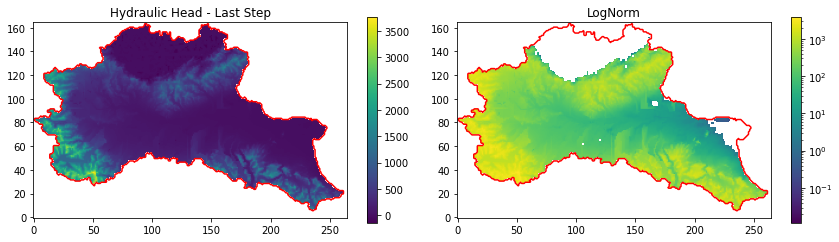

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
for ax, norm, title in zip(axes, [None, LogNorm()], ['Hydraulic Head - Last Step', 'LogNorm']):
    im = ax.imshow(Hhead, cmap='viridis', origin='lower', norm=norm)
    fig.colorbar(im, ax=ax, shrink=0.5)
    ax.contour(np.flipud(watershed), levels=[0.5], colors='red', linewidths=1.5)
    ax.set_title(title)
plt.tight_layout()

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
for ax, norm, title in zip(axes, [None, LogNorm()], ['Water Table Depth - Last Step', 'LogNorm']):
    im = ax.imshow(wtd_adda[-1, ...], cmap='viridis', origin='lower', norm=norm)
    fig.colorbar(im, ax=ax, shrink=0.5)
    ax.contour(np.flipud(watershed), levels=[0.5], colors='red', linewidths=1.5)
    ax.set_title(title)
plt.tight_layout()

#### Pressure head and Saturation

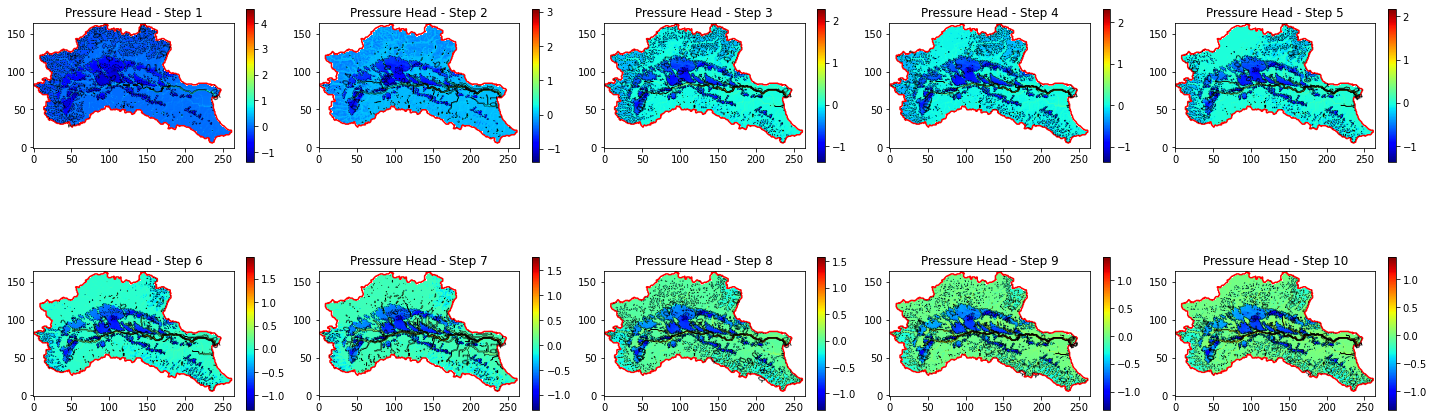

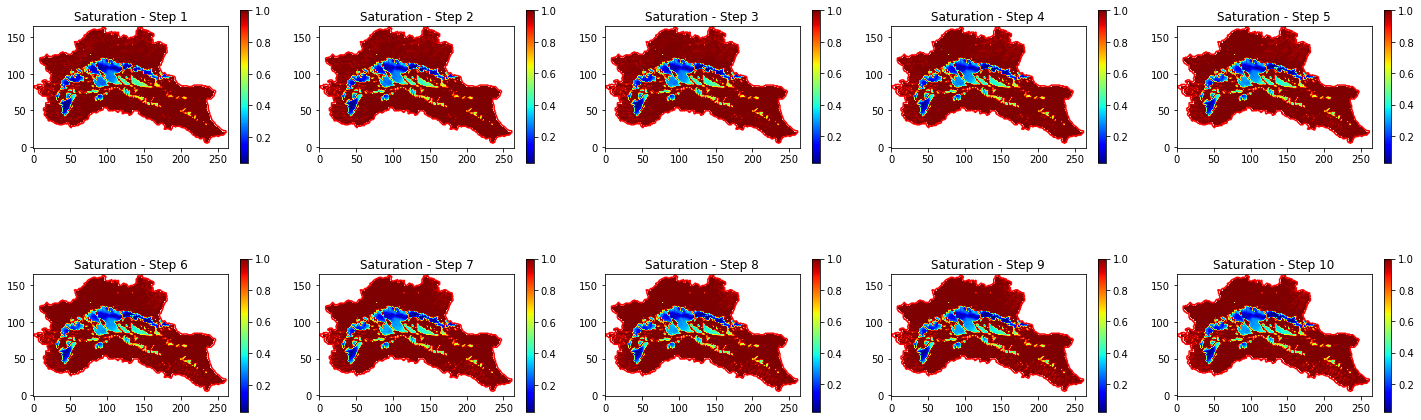

In [23]:
# timestep = [0, 10, 20, 30, 40, 50, 60, 70, 80, 100]
timestep = [0, 12, 24, 36, 48, 60, 72, 84, 96, 108, 120]
pressures, saturs = [], []
# for t in range(10):
for t in timestep:
    pressure = read_pfb(folder+runname+'.out.press.'+str(t).zfill(5)+'.pfb')
    # mask=np.array(pressure>-1000000)*1.0
    # mask[mask == 0] = np.nan
    pressure[pressure < -10000000] = np.nan
    pressures.append(pressure[-1]) # 8 is the index of the top layer, index 10 is out of bounds for axis 0 with size 9

    saturation = read_pfb(folder+runname+'.out.satur.'+str(t).zfill(5)+'.pfb')
    saturation[saturation < -4000] = np.nan
    saturs.append(saturation[-1])

fig, axes = plt.subplots(2, 5, figsize=(20, 8))
for i in range(10):
    ax = axes[i // 5, i % 5]
    im = ax.imshow(pressures[i], cmap='jet', origin='lower')
    ax.contour(np.flipud(watershed), levels=[0.5], colors='red', linewidths=1.5)

    ax.set_title(f'Pressure Head - Step {i+1}')
    fig.colorbar(im, ax=ax, shrink=0.5)
    contour = ax.contour(pressures[i], levels=np.linspace(np.nanmin(pressures[i]), np.nanmax(pressures[i]), 10), colors='black', linewidths=0.5)
    ax.clabel(contour, inline=True, fontsize=8, fmt='%1.1f')
plt.tight_layout()

fig, axes = plt.subplots(2, 5, figsize=(20, 8))
for i in range(10):
    ax = axes[i // 5, i % 5]
    im = ax.imshow(saturs[i], cmap='jet', origin='lower')
    ax.contour(np.flipud(watershed), levels=[0.5], colors='red', linewidths=1.5)

    ax.set_title(f'Saturation - Step {i+1}')
    fig.colorbar(im, ax=ax, shrink=0.5)
plt.tight_layout()


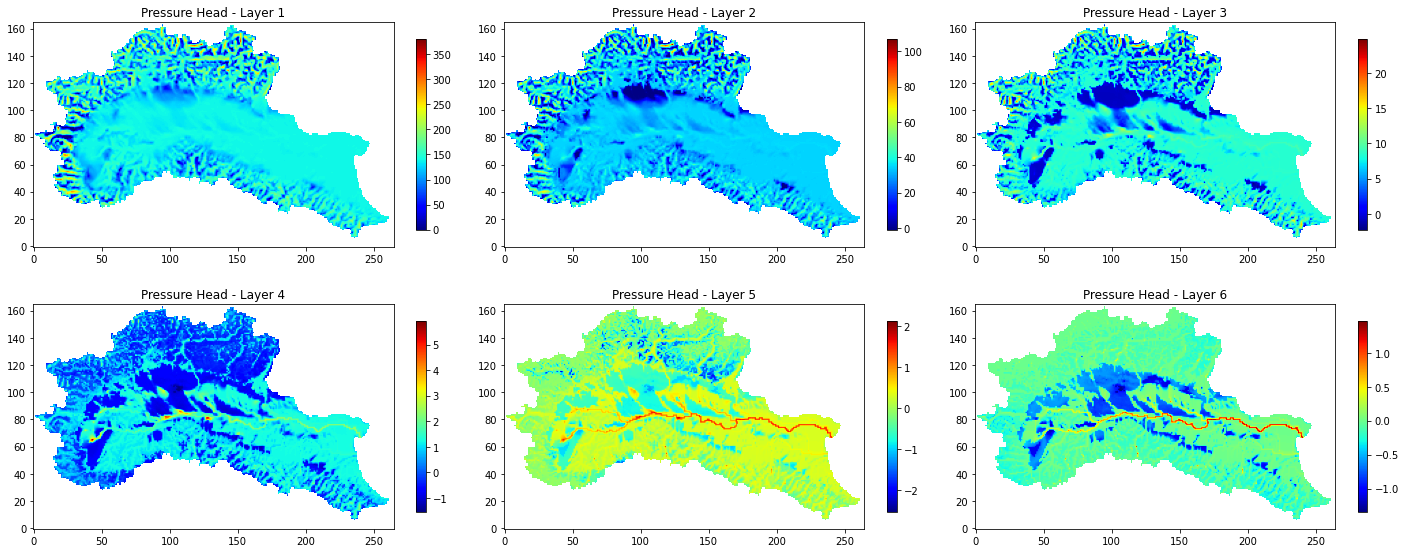

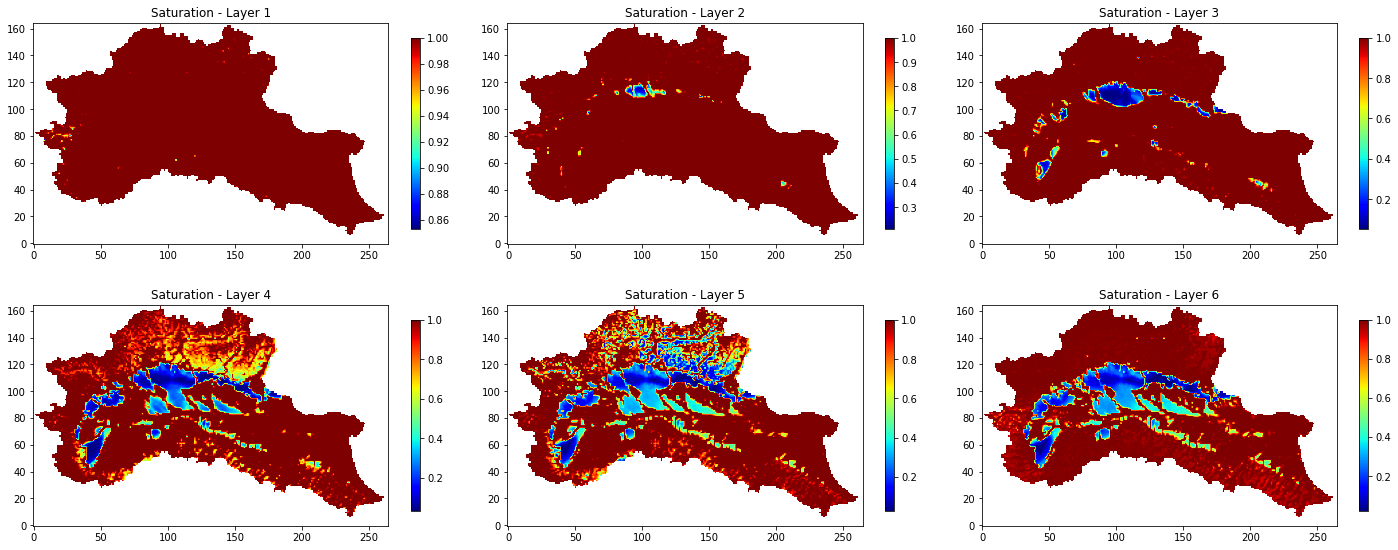

In [20]:
# Plot the pressure of each layer
fig, axes = plt.subplots(2, 3, figsize=(20, 8))
for i in range(6):
    ax = axes[i // 3, i % 3]
    im = ax.imshow(pressure[i, ...], cmap='jet', origin='lower')
    # ax.contour(np.flipud(watershed), levels=[0.5], colors='red', linewidths=1.5)

    ax.set_title(f'Pressure Head - Layer {i+1}')
    fig.colorbar(im, ax=ax, shrink=0.7)
    # contour = ax.contour(pressure[i, ...], levels=np.linspace(np.nanmin(pressures[0][i]), np.nanmax(pressures[0][i]), 10), colors='black', linewidths=0.5)
    # ax.clabel(contour, inline=True, fontsize=8, fmt='%1.1f')
plt.tight_layout()

# Plot the saturation of each layer
fig, axes = plt.subplots(2, 3, figsize=(20, 8))
for i in range(6):
    ax = axes[i // 3, i % 3]
    im = ax.imshow(saturation[i, ...], cmap='jet', origin='lower')
    # ax.contour(np.flipud(watershed), levels=[0.5], colors='red', linewidths=1.5)

    ax.set_title(f'Saturation - Layer {i+1}')
    fig.colorbar(im, ax=ax, shrink=0.7)
    # contour = ax.contour(saturation[i, ...], levels=np.linspace(np.nanmin(saturs[0][i]), np.nanmax(saturs[0][i]), 10), colors='black', linewidths=0.5)
    # ax.clabel(contour, inline=True, fontsize=8, fmt='%1.1f')
plt.tight_layout()

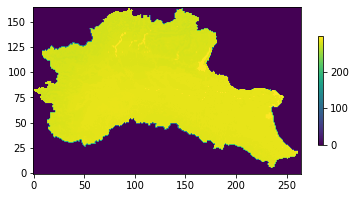

In [34]:
clm = read_pfb ('/home/dica/huiminw/Work/Codes/Py/lombardy/0_clm_2023/Calibration.out.clm_output.00109.C.pfb')

# clm = read_pfb('/home/dica/huiminw/Work/Codes/Py/lombardy/0_clm_2023/Calibration_clm_crop_veg_m_landfrac.pfb')

plt.imshow(clm[-1, :, :]*np.flip(watershed, axis=0), cmap='viridis', origin='lower')
plt.colorbar(shrink=0.5)


#### Subsurface Velocities, plz conside about the runoff 

In [ ]:
layer = 0
velx, vely, vel = [], [], []
# for t in range(10):
for t in timestep:
    velx.append(read_pfb(folder+runname+'.out.velx.'+str(t).zfill(5)+'.pfb'))
    vely.append(read_pfb(folder+runname+'.out.vely.'+str(t).zfill(5)+'.pfb'))

velx = np.array(velx)
vely = np.array(vely)

# velx = velx[:, :, :, 1:37] # remove the boundary cells
# vely = vely[:, :, 0:40, :] # remove the boundary cells
# velx = velx[:, :, : , 1:73] # remove the boundary cells
# vely = vely[:, :, 0:80, :] # remove the boundary cells
vel = np.sqrt(velx**2 + vely**2)

fig, axes = plt.subplots(2, 5, figsize=(20, 8))
for i in range(10):
    ax = axes[i // 5, i % 5]
    im = ax.imshow(velx[i][layer], cmap='jet', origin='lower')
    ax.contour(np.flipud(watershed), levels=[0.5], colors='red', linewidths=1.5)

    ax.set_title(f'Velocity X - Step {i+1}')
    fig.colorbar(im, ax=ax, shrink=0.7)
    # ax.quiver(np.arange(velx[i][layer].shape[1]), np.arange(velx[i][layer].shape[0]),
    #     np.zeros_like(velx[i][layer]), velx[i][layer], color='k', scale=0.05, scale_units='xy', angles='xy', width=0.005)
plt.tight_layout()

fig, axes = plt.subplots(2, 5, figsize=(20, 8))
for i in range(10):
    ax = axes[i // 5, i % 5]
    im = ax.imshow(vely[i][layer], cmap='jet', origin='lower')
    ax.contour(np.flipud(watershed), levels=[0.5], colors='red', linewidths=1.5)
    ax.set_title(f'Velocity Y - Step {i+1}')
    fig.colorbar(im, ax=ax, shrink=0.7)
plt.tight_layout()


Bottom layer south side vely


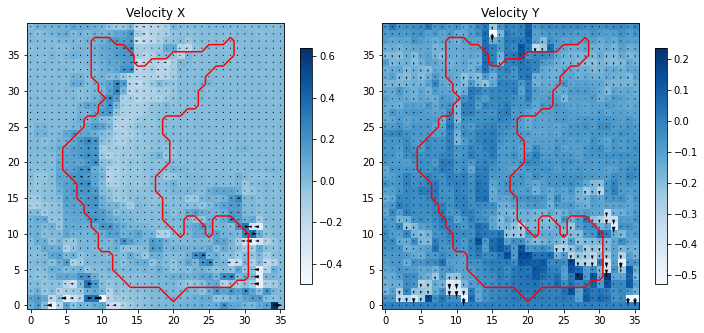

In [ ]:
layer_id = 0
velx_end, vely_end = velx[-1, ...], vely[-1, ...]
print('Bottom layer south side vely')

vel_end = np.sqrt(velx_end**2 + vely_end**2)

fig, axes = plt.subplots(1, 2, figsize=(10,5))
imx = axes[0].imshow(velx_end[layer_id], cmap='Blues', origin='lower')
axes[0].contour(np.flipud(watershed), levels=[0.5], colors='red', linewidths=1.5)
# add the arrow to show the direction of the flow
axes[0].quiver(np.arange((velx_end[layer_id]).shape[1]), np.arange((velx_end[layer_id]).shape[0]),
    (velx_end[layer_id]), np.zeros_like((velx_end[layer_id])), color='k', scale=0.5, scale_units='xy', angles='xy', width=0.005)
axes[0].set_title('Velocity X')
fig.colorbar(imx, ax=axes[0], shrink=0.7)

imy = axes[1].imshow(vely_end[layer_id], cmap='Blues', origin='lower')
axes[1].contour(np.flipud(watershed), levels=[0.5], colors='red', linewidths=1.5)
axes[1].quiver(np.arange((vely_end[layer_id]).shape[1]), np.arange((vely_end[layer_id]).shape[0]),
    np.zeros_like((vely_end[layer_id])), (vely_end[layer_id]), color='k', scale=0.5, scale_units='xy', angles='xy', width=0.005)
axes[1].set_title('Velocity Y')
fig.colorbar(imy, ax=axes[1], shrink=0.7)
plt.tight_layout()

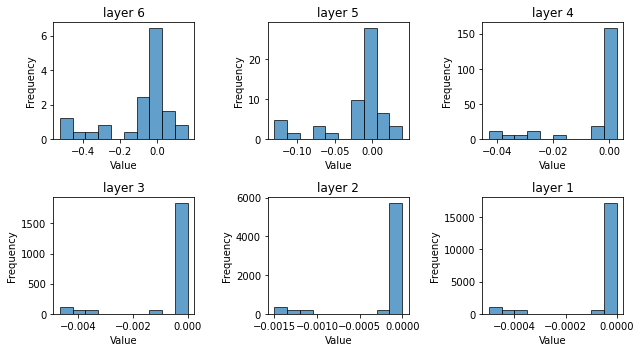

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(9, 5))
for i in range(6):
    ax = axs[i // 3, i % 3]
    im = ax.hist(vely_end[i, 1, :].flatten(), bins=10, density=True, edgecolor='black', alpha=0.7)
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')
    ax.set_title(f'layer {6-i}')
plt.tight_layout()


Text(0.5, 1.0, 'magnitude of velocity')

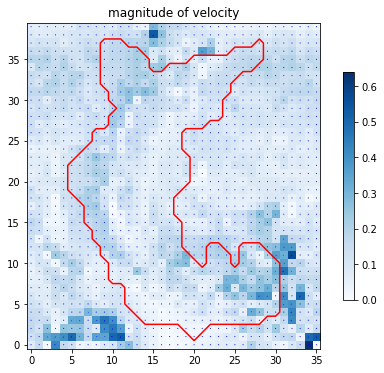

In [ ]:
x, y = np.meshgrid(np.arange(velx_end[layer_id].shape[1]), np.arange(velx_end[layer_id].shape[0]))
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(vel_end[layer_id], cmap='Blues', origin='lower')

ax.contour(np.flipud(watershed), levels=[0.5], colors='red', linewidths=1.5)
ax.quiver(x, y, velx_end[layer_id], vely_end[layer_id], color='blue', scale=2, scale_units='xy', angles='xy', width=0.004)
fig.colorbar(im, ax=ax, shrink=0.7)
plt.title('magnitude of velocity')

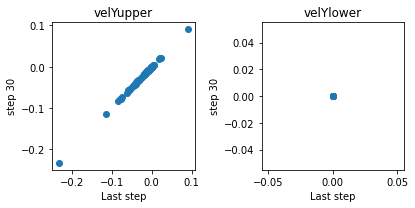

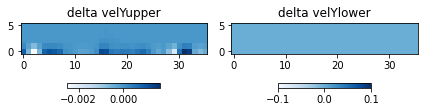

In [ ]:
step = 3
slices = [-1, 0]
tittles = ['velYupper', 'velYlower']

fig, axes = plt.subplots(1, 2, figsize=(6, 3))
for ax, slice, title in zip(axes, slices, tittles):
    ax.scatter(vely[-1, :, slice, :], vely[step, :, slice, :])
    ax.set_xlabel('Last step')
    ax.set_ylabel('step '+str(step*10))
    ax.set_title(title)
plt.tight_layout()

# plt.scatter(vely[-1, :, 0, :], vely[1, :, 0, :], c='r')
# # plt.scatter(vely[-1, :, -1, :], vely[1, :, -1, :], c='b')
# plt.xlabel('Last step')
# plt.ylabel('step '+str(step*10))
# plt.title('velYupper')

diff_velyu = vely[-1, :, -1, :]- vely[step, :, -1, :]
diff_velyl = vely[-1, :, 0, :] - vely[step, :, 0, :]
diff_vel = [diff_velyu, diff_velyl]
fig, axes = plt.subplots(1, 2, figsize=(6, 3))
for ax, diff, title in zip(axes, diff_vel, tittles):
    im = ax.imshow(diff, cmap='Blues', origin='lower')
    ax.set_title('delta '+title)
    fig.colorbar(im, ax=ax, orientation='horizontal', shrink=0.5)
plt.tight_layout()

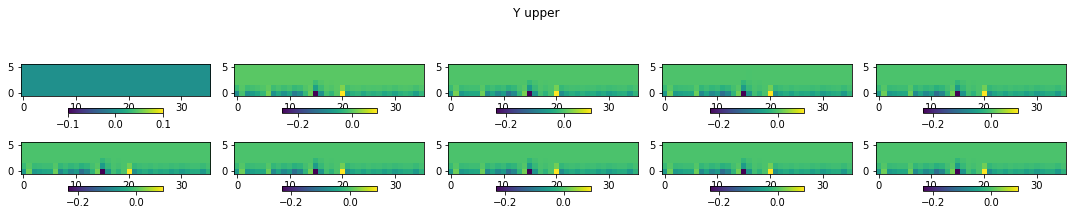

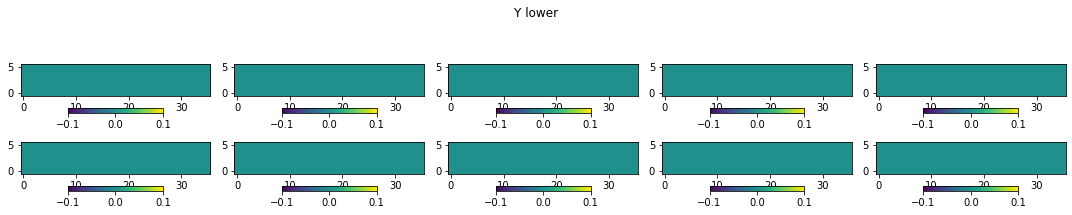

In [ ]:
fig, axes = plt.subplots(2, 5, figsize=(15, 3))
fig.suptitle('Y upper')
for i in range(10):
    ax = axes[i // 5, i % 5]
    im = ax.imshow(vely[i, :, -1, :], cmap='viridis', origin='lower')
    plt.colorbar(im, ax=ax, orientation='horizontal', shrink=0.5)
plt.tight_layout()

fig, axes = plt.subplots(2, 5, figsize=(15, 3))
fig.suptitle('Y lower')
for i in range(10):
    ax = axes[i // 5, i % 5]
    im = ax.imshow(vely[i, :, 0, :], cmap='viridis', origin='lower')
    plt.colorbar(im, ax=ax, orientation='horizontal', shrink=0.5)
plt.tight_layout()